In [2]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from causalinference import CausalModel

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
data = pd.read_csv('malocclusion.csv')

In [4]:
data.head()

,dANB,dPPPM,dIMPA,dCoA,dGoPg,dCoGo,dT,Growth,Treatment
0,-3.2,-1.1,-4.2,1.0,4.0,3.7,5,0,0
1,-0.6,-0.5,3.8,2.6,-0.1,1.4,3,1,0
2,-1.6,-3.1,-6.0,4.3,4.2,7.1,5,0,0
3,-1.1,-2.1,-12.1,14.1,20.7,17.5,9,0,0
4,-1.1,0.0,-6.7,7.7,8.8,11.0,5,0,0


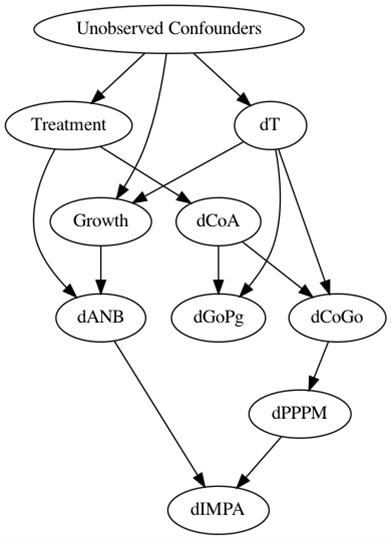

### the effect of the 'Treatment' on 'Growth' 

Directed/Causal path : NO

Treatment parents are unmeasured

We have unmeasured variables influences both treatment and outcome, so we can estimate causal effect by finding a mediator between our treatment variable and the outcome - front door adjustment set: 

{'dCoA'}

for example: 'Treatment' --> 'dCoA' --> 'dCoCo' <-- 'dT' --> 'Growth'

#### Naive estimator of ATE:

In [5]:
print('mean of "Growth" | "Treatment = 0" :', (round(data.Growth[data.Treatment == 0].mean(), 3)))
print('mean of "Growth" | "Treatment = 1" :', (round(data.Growth[data.Treatment == 1].mean(), 3)))
print('means diff', (round(data.Growth[data.Treatment == 1].mean() - data.Growth[data.Treatment == 0].mean(), 3)))

mean of "Growth" | "Treatment = 0" : 0.338
mean of "Growth" | "Treatment = 1" : 0.485
means diff 0.147


#### Regression
Let's try taking our adjustment set into account and use linear regression to estimate ATE:

In [6]:
m = smf.ols('Growth ~ Treatment + dCoA', data=data)
fitted = m.fit()
print(fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                 Growth   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     3.110
Date:                Sun, 08 May 2022   Prob (F-statistic):             0.0477
Time:                        13:28:01   Log-Likelihood:                -98.085
No. Observations:                 143   AIC:                             202.2
Df Residuals:                     140   BIC:                             211.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4066      0.068      5.949      0.0

Current interim result ATE = 0.250

#### Propensity score weighting

In [7]:
# classifier to estimate the propensity score
cls = LogisticRegression()

# calibration of the classifier
cls_cc = CalibratedClassifierCV(cls)

X = data[['dCoA']]
y = data['Treatment']
cls_cc.fit(X, y)
data['e1'] = cls_cc.predict_proba(X)[:,1].tolist()

C:\Users\vn8209\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\vn8209\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_folds = np.zeros(n_samples, dtype=np.int)
C:\Users\vn8209\AppData\Local\Continuum\anaconda3\lib\site-packages\sklear

In [12]:
print(round(data.e1[data.Treatment == 0].mean(), 3))
print(round(data.e1[data.Treatment == 1].mean(), 3))
print(round(data.e1[data.Treatment == 0].var(), 3))
print(round(data.e1[data.Treatment == 1].var(), 3))

0.307
0.643
0.05
0.052


Variances of propensity scores are similar in Treatment/ non_Treatment group --> we can continue with this method

In [13]:
data['w1'] = data['Treatment'] / data['e1'] + (1 - data['Treatment']) / (1 - data['e1'])

In [14]:
m = smf.wls('Growth ~ Treatment + dCoA', data=data, weights=data['w1'])
fitted = m.fit()
print(fitted.summary())

                            WLS Regression Results                            
Dep. Variable:                 Growth   R-squared:                       0.141
Model:                            WLS   Adj. R-squared:                  0.129
Method:                 Least Squares   F-statistic:                     11.54
Date:                Sun, 08 May 2022   Prob (F-statistic):           2.30e-05
Time:                        13:29:48   Log-Likelihood:                -98.805
No. Observations:                 143   AIC:                             203.6
Df Residuals:                     140   BIC:                             212.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4113      0.074      5.529      0.0

Current interim result ATE = 0.298

#### Doubly robust estimator

In [15]:
from sklearn.linear_model import LinearRegression

y0 = LinearRegression().fit(data[data.Treatment == 0][['dCoA']], data[data.Treatment == 0]['Growth']).predict(data[['dCoA']])
y1 = LinearRegression().fit(data[data.Treatment == 1][['dCoA']], data[data.Treatment == 1]['Growth']).predict(data[['dCoA']])

data['DR01'] = (1-data['Treatment']) * (data['Growth'] - y0)/(1-data['e1']) + y0
data['DR11'] =    data['Treatment']  * (data['Growth'] - y1)/   data['e1']  + y1

In [16]:
round(data['DR11'].mean() - data['DR01'].mean(), 3)

0.272

Current interim result ATE = 0.272

#### Matching with Machalanobis distance

In [19]:
adjustment_set = ['dCoA']

causal = CausalModel(
    Y=data['Growth'].values, # outcome
    D=data['Treatment'].values, # treatment
    X=data[adjustment_set].values
)
causal.est_via_matching(bias_adj=True)
print(causal.estimates)


Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE      0.423      0.196      2.155      0.031      0.038      0.807
           ATC      0.429      0.301      1.428      0.153     -0.160      1.019
           ATT      0.415      0.188      2.213      0.027      0.048      0.783



Current interim result ATE = 0.423, ATET = 0.415

#### Conclusion about ATE experiments

In principle, I got fairly close values, except "Machalanobis distance" with causalinference lib. I will stop at the method "Propensity score weighting" because it's base method, it shows good variences and it should work reliably on a small data set with limits on exact matching. 



#### ATET

To get the ATET, I use the library PsmPy on base Propensity score matching. 

$$ ATET = E(y_1i|T=1) - E(y_0i|T=1) $$


Propensity score matching (PSM) directly estimates ATET. So we need to get pairs to compare a unit in treatment group to a similar unit in control group at individual level. ATET will be just the average of the individual treatment effects. 

Let's simulate matching with the option "replacement=True": determines whethermacthing will happen with or without replacement. When replacement is True units from control group may repeted. 

Hence it will be necessary to aggregate the results from a large number of iterations:

In [21]:
from psmpy import PsmPy
from psmpy.functions import cohenD
from psmpy.plotting import *

In [22]:
df = data[['Treatment', 'dCoA']]
df['index'] = list(range(len(df.index)))

C:\Users\vn8209\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [23]:
answer = []
for i in range(1000):
    psm = PsmPy(df, treatment='Treatment', indx='index')
    psm.logistic_ps()
    psm.knn_matched(matcher='propensity_logit', replacement=True, caliper=None)
    matched = psm.matched_ids
    x = matched.merge(data, left_on='index', right_on=data.index)
    y = x.merge(data, left_on='matched_ID', right_on=data.index)
    y['ATET'] = y['Growth_x'] - y['Growth_y']
    answer.append(y['ATET'].mean())
round(sum(answer)/len(answer), 3)

C:\Users\vn8209\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\vn8209\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\vn820

0.38

In [32]:
psm.matched_ids.head()

,index,matched_ID
0,8,75
1,25,87
2,29,45
3,32,50
4,40,92


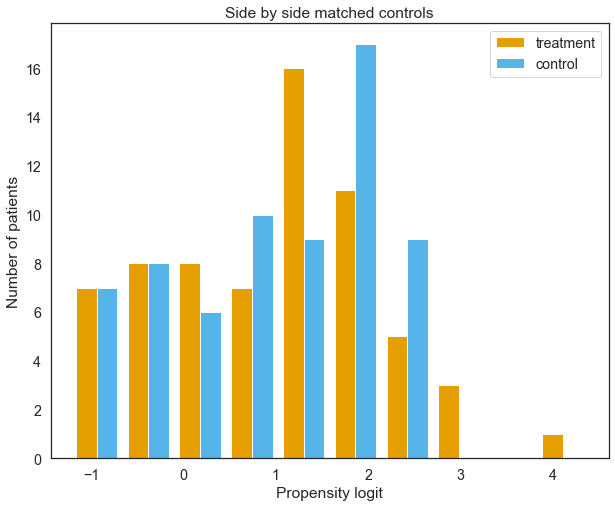

In [33]:
psm.plot_match(Title='Side by side matched controls', Ylabel='Number of patients', Xlabel= 'Propensity logit', names = ['treatment', 'control'], save=True)

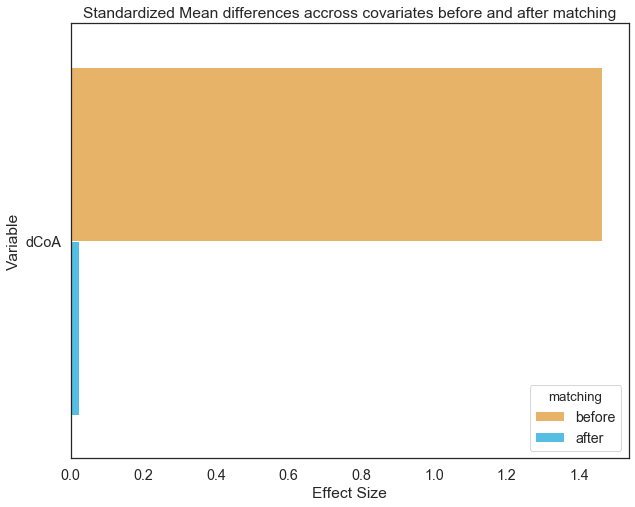

In [34]:
psm.effect_size_plot(save=False)

#### Results

Adjustment set:   {'dCoA'}

ATE = 0.298

ATET = 0.380

### the effect of the 'Treatment' on 'Growth' 

Directed/Causal path : 'Treatment' ---> 'dANB' 

Treatment parents are unmeasured

Undirected path give us the following backdoor (starts with an arrow into 'Treatment' and ends with an arrow into 'dANB') adjustment set:

{'Growth'}, {'Growth', 'dT'} 

'Treatment' <-- 'Onobserved Confounders' --> 'Growth' --> 'dANB'

'Treatment' <-- 'Onobserved Confounders' --> 'dT' --> 'Growth' --> 'dANB'

Naive estimator of ATE:

In [35]:
print('mean of "dANB" | "Treatment = 0" :', (round(data.dANB[data.Treatment == 0].mean(), 3)))
print('mean of "dANB" | "Treatment = 1" :', (round(data.dANB[data.Treatment == 1].mean(), 3)))
print('means diff', (round(data.dANB[data.Treatment == 1].mean() - data.dANB[data.Treatment == 0].mean(), 3)))

mean of "dANB" | "Treatment = 0" : -1.164
mean of "dANB" | "Treatment = 1" : 0.865
means diff 2.029


#### Regression
Let's try taking our adjustment set into account and use linear regression to estimate ATE:

In [36]:
m = smf.ols('dANB ~ Treatment + Growth + dT', data=data)
fitted = m.fit()
print(fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                   dANB   R-squared:                       0.409
Model:                            OLS   Adj. R-squared:                  0.397
Method:                 Least Squares   F-statistic:                     32.12
Date:                Sun, 08 May 2022   Prob (F-statistic):           7.78e-16
Time:                        13:47:16   Log-Likelihood:                -250.87
No. Observations:                 143   AIC:                             509.7
Df Residuals:                     139   BIC:                             521.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.4021      0.276     -5.075      0.0

Current interim result ATE = 1.933

#### Propensity score weighting

In [37]:
cls = LogisticRegression()
cls = CalibratedClassifierCV(cls)

X = data[['Growth', 'dT']]
y = data['Treatment']
cls.fit(X, y)
data['e2'] = cls.predict_proba(X)[:,1].tolist()
data.head()

C:\Users\vn8209\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\vn8209\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_folds = np.zeros(n_samples, dtype=np.int)
C:\Users\vn8209\AppData\Local\Continuum\anaconda3\lib\site-packages\sklear

,dANB,dPPPM,dIMPA,dCoA,dGoPg,dCoGo,dT,Growth,Treatment,e1,w1,DR01,DR11,e2
0,-3.2,-1.1,-4.2,1.0,4.0,3.7,5,0,0,0.146359,1.171453,-0.072590,0.528620,0.425823
1,-0.6,-0.5,3.8,2.6,-0.1,1.4,3,1,0,0.222496,1.286167,1.180421,0.519681,0.486885
2,-1.6,-3.1,-6.0,4.3,4.2,7.1,5,0,0,0.332908,1.499043,-0.155856,0.510183,0.425823
3,-1.1,-2.1,-12.1,14.1,20.7,17.5,9,0,0,0.915391,11.819018,0.189737,0.455434,0.546105
4,-1.1,0.0,-6.7,7.7,8.8,11.0,5,0,0,0.603086,2.519438,-0.300656,0.491189,0.425823


In [38]:
data['w2'] = data['Treatment'] / data['e2'] + (1 - data['Treatment']) / (1 - data['e2'])

In [41]:
print(round(data.e2[data.Treatment == 0].mean(), 3))
print(round(data.e2[data.Treatment == 1].mean(), 3))
print(round(data.e2[data.Treatment == 0].var(), 4))
print(round(data.e2[data.Treatment == 1].var(), 4))

0.438
0.5
0.005
0.0044


In [42]:
m = smf.wls('dANB ~ Treatment + Growth + dT', data=data, weights=data['w2'])
fitted = m.fit()
print(fitted.summary())

                            WLS Regression Results                            
Dep. Variable:                   dANB   R-squared:                       0.384
Model:                            WLS   Adj. R-squared:                  0.371
Method:                 Least Squares   F-statistic:                     28.93
Date:                Sun, 08 May 2022   Prob (F-statistic):           1.35e-14
Time:                        13:48:53   Log-Likelihood:                -254.83
No. Observations:                 143   AIC:                             517.7
Df Residuals:                     139   BIC:                             529.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.3907      0.294     -4.725      0.0

Current interim result ATE = 1.929

In [43]:
from sklearn.linear_model import LinearRegression

y0 = LinearRegression().fit(data[data.Treatment == 0][['Growth', 'dT']], data[data.Treatment == 0]['dANB']).predict(data[['Growth', 'dT']])
y1 = LinearRegression().fit(data[data.Treatment == 1][['Growth', 'dT']], data[data.Treatment == 1]['dANB']).predict(data[['Growth', 'dT']])

data['DR02'] = (1-data['Treatment']) * (data['dANB'] - y0)/(1-data['e2']) + y0
data['DR12'] =    data['Treatment']  * (data['dANB'] - y1)/   data['e2']  + y1

In [44]:
round(data['DR12'].mean() - data['DR02'].mean(), 3)

1.874

Current interim result ATE = 1.874

In [54]:
adjustment_set = ['Growth', 'dT']

causal = CausalModel(
    Y=data['dANB'].values, # outcome
    D=data['Treatment'].values, # treatment
    X=data['e2'].values
)
causal.est_via_matching(bias_adj=True)
print(causal.estimates)


Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE      1.748      0.336      5.207      0.000      1.090      2.406
           ATC      1.626      0.402      4.045      0.000      0.838      2.415
           ATT      1.890      0.382      4.947      0.000      1.141      2.638



C:\Users\vn8209\AppData\Local\Continuum\anaconda3\lib\site-packages\causalinference\estimators\matching.py:100: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return np.linalg.lstsq(X, Y)[0][1:]  # don't need intercept coef


Current interim result ATE = 1.748, ATET = 1.890

Next I will use the conclusions and actions from the previous block:

In [49]:
df1 = data[['Treatment', 'Growth', 'dT']]
df1['index'] = list(range(len(df1.index)))

C:\Users\vn8209\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [50]:
answer = []
for i in range(1000):
    psm = PsmPy(df1, treatment='Treatment', indx='index')
    psm.logistic_ps()
    psm.knn_matched(matcher='propensity_logit', replacement=True, caliper=None)
    matched = psm.matched_ids
    x = matched.merge(data, left_on='index', right_on=data.index)
    y = x.merge(data, left_on='matched_ID', right_on=data.index)
    y['ATET'] = y['dANB_x'] - y['dANB_y']
    answer.append(y['ATET'].mean())
round(sum(answer)/len(answer), 3)

C:\Users\vn8209\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\vn8209\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\vn820

2.072

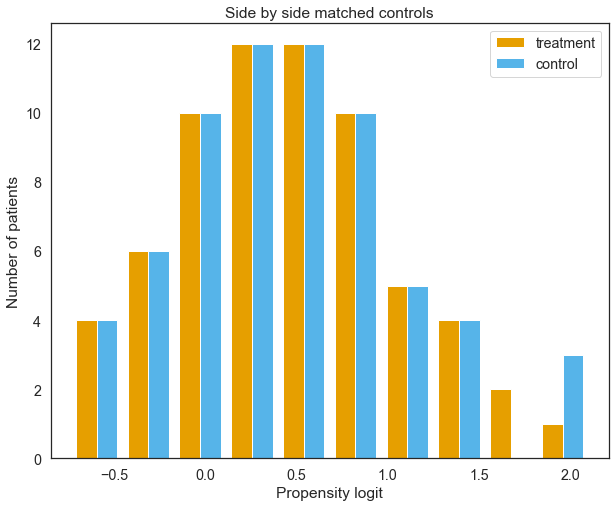

In [51]:
psm.plot_match(Title='Side by side matched controls', Ylabel='Number of patients', Xlabel= 'Propensity logit', names = ['treatment', 'control'], save=True)

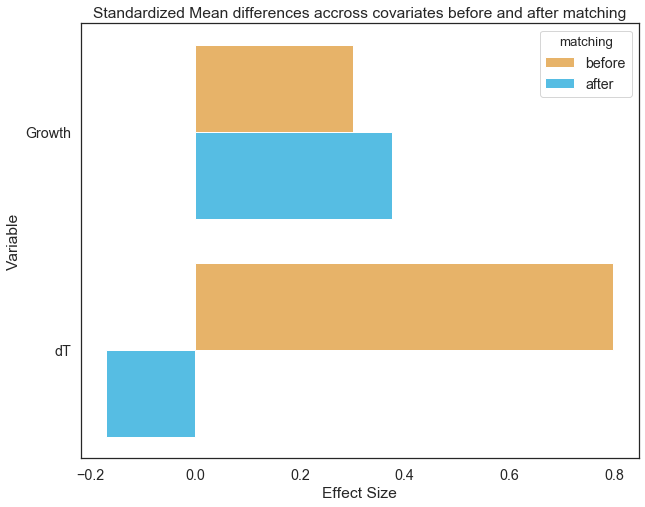

In [52]:
psm.effect_size_plot(save=False)

#### Results

Adjustment set:  {'Growth', 'dT'}

ATE = 1.929

ATET = 2.072